In [1]:
# установка дополнительной библиотеки
!pip3 install pmdarima

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima_model import ARMAResults,ARIMAResults
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
from statsmodels.tsa.stattools import adfuller


from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
from dateutil.parser import parse
from scipy import stats
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

In [3]:
# тест Дики-Фуллера
# 0 гипотеза: ряд данных не стационарен
# альтернативная гипотеза: ряд данных стационарен
# Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда

def adf_test(series,title=''):

    result = adfuller(series.dropna(),autolag='AIC')

    labels = ['ADF тест','p-value','# lags used','# наблюдения']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'критическое значение ({key})']=val

    print(out.to_string())

    if result[1] <= 0.05:
        print("Сильные доказательства против нулевой гипотезы")
        print("Отменяем 0 гипотезу")
        print("Данные стационарны")
    else:
        print("Слабые доказательства против нулевой гипотезы")
        print("Не отменяем 0 гипотезу")
        print("Данные не стационарны")

In [1]:
# загрузка данных
df= pd.read_csv("international-airline-passengers.csv", index_col="Month", parse_dates= True)

NameError: name 'pd' is not defined

In [12]:
df.head()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [13]:
# длина данных
len(df)

144

In [14]:
df=df.rename(columns={"International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60":'Thousands of Passengers'},inplace=True)

In [15]:
# удаление пропущенных значений
df.dropna(inplace=True)

AttributeError: 'NoneType' object has no attribute 'dropna'

In [16]:
# длина данных после удаления
len(df)

TypeError: object of type 'NoneType' has no len()

In [ ]:
# создаем индекс (уникальность) по полю дата
df.index= pd.to_datetime(df.index)

In [ ]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [ ]:
# дескриптивная аналитики
df.describe()

,Thousands of Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


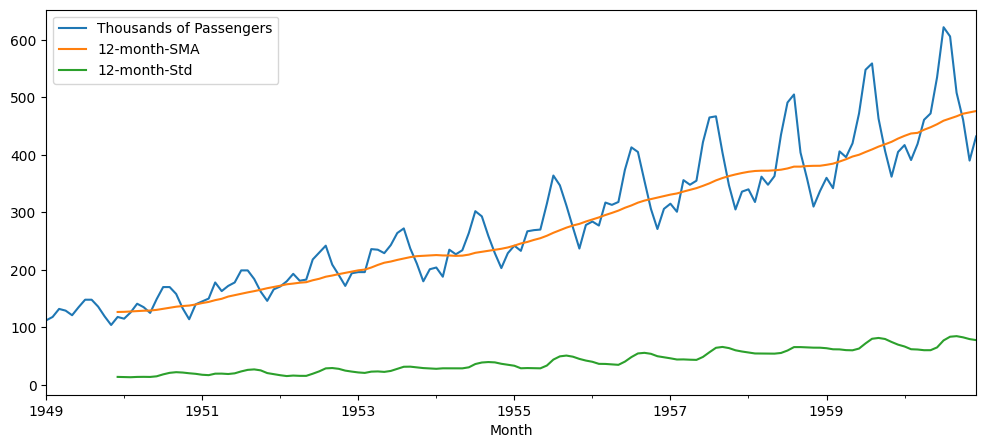

In [ ]:
# дескриптивная аналитики
df['12-month-SMA'] = df['Thousands of Passengers'].rolling(window=12).mean()
df['12-month-Std'] = df['Thousands of Passengers'].rolling(window=12).std()

df[['Thousands of Passengers','12-month-SMA','12-month-Std']].plot(figsize=(12,5));

In [ ]:
# наглядно показываем какие есть столбцы
df.columns

Index(['Thousands of Passengers', '12-month-SMA', '12-month-Std'], dtype='object')

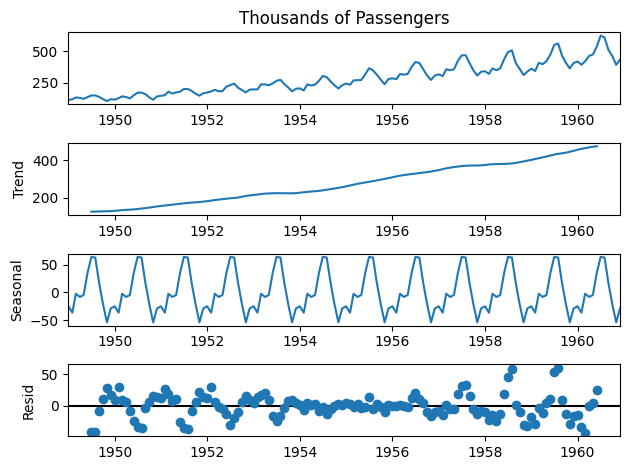

In [ ]:
# сезонная декомпозиция
ssn= seasonal_decompose(df["Thousands of Passengers"], model="add")
ssn.plot();

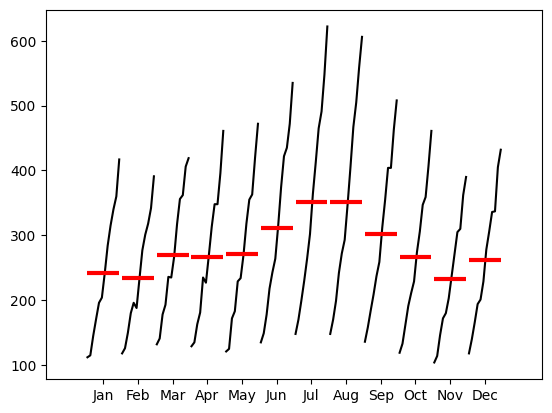

In [ ]:
# построим новый вид графика
month_plot(df['Thousands of Passengers']);

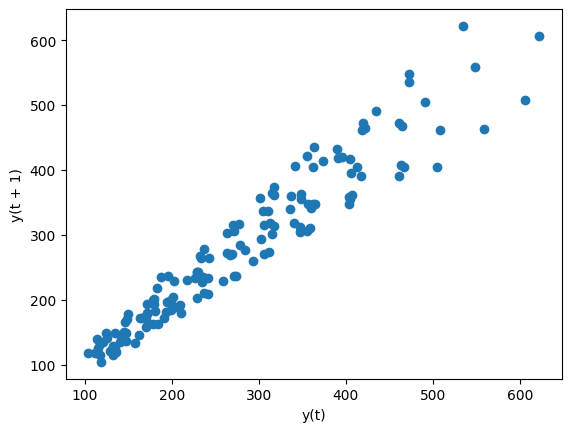

In [ ]:
# автокорреляция значения t+1 (следующий лаг времени) от текущего (t)
# здесь есть строгая корреляция
lag_plot(df['Thousands of Passengers']);

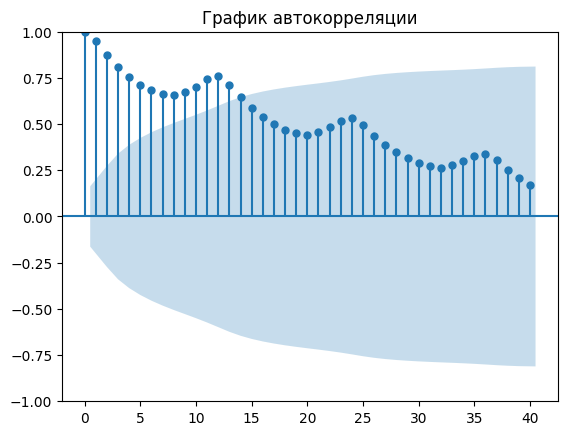

In [ ]:
# ACF
title = 'График автокорреляции'
lags = 40
plot_acf(df["Thousands of Passengers"],title=title,lags=lags);

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


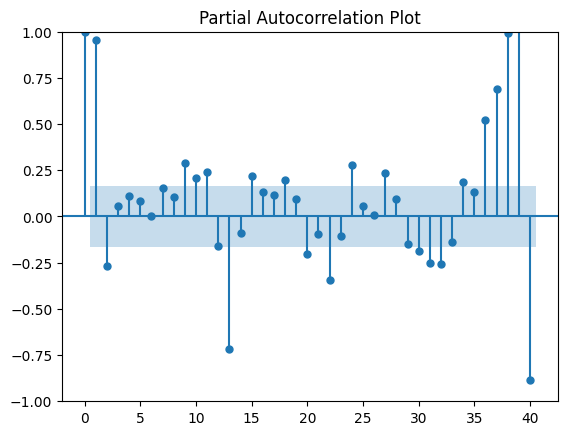

In [ ]:
# PACF
title = 'Partial Autocorrelation Plot'
lags = 40
plot_pacf(df["Thousands of Passengers"],title=title,lags=lags);

In [ ]:
# тест на стационарность
adf_test(df["Thousands of Passengers"])

ADF тест                        0.815369
p-value                         0.991880
# lags used                    13.000000
# наблюдения                  130.000000
критическое значение (1%)      -3.481682
критическое значение (5%)      -2.884042
критическое значение (10%)     -2.578770
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


<Axes: xlabel='Month'>

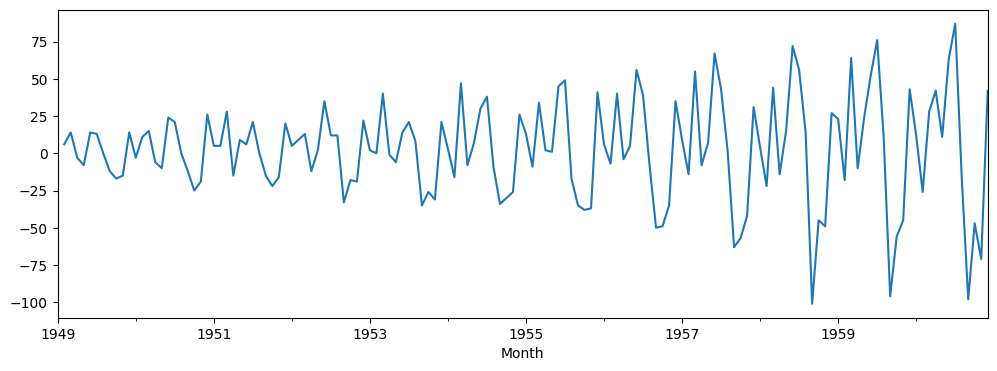

In [ ]:
# сконвертируем нестационарный ряд в стационарный
# Понятие стационарного временного ряда означает, что его среднее значение не изменяется во времени, т. е. временной ряд не имеет тренда
df["difference_1"]= diff(df["Thousands of Passengers"], k_diff=1)
df["difference_1"].plot(figsize=(12,4))

In [ ]:
adf_test(df["difference_1"])

ADF тест                       -2.829267
p-value                         0.054213
# lags used                    12.000000
# наблюдения                  130.000000
критическое значение (1%)      -3.481682
критическое значение (5%)      -2.884042
критическое значение (10%)     -2.578770
Слабые доказательства против нулевой гипотезы
Не отменяем 0 гипотезу
Данные не стационарны


<Axes: xlabel='Month'>

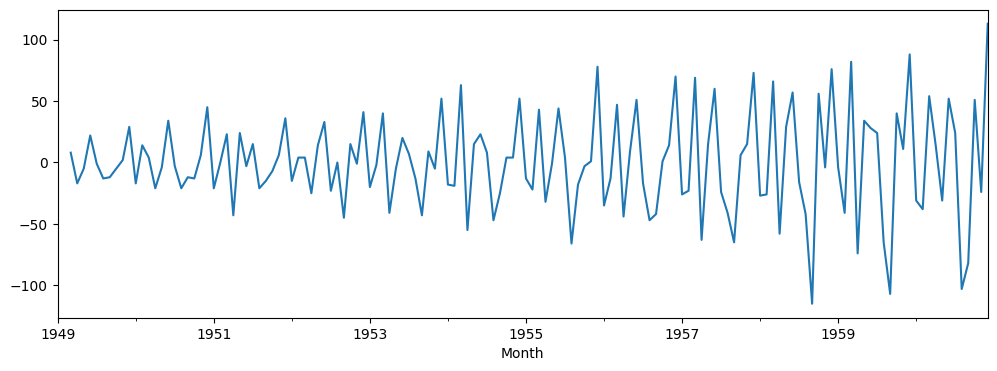

In [ ]:
df["difference_2"]= diff(df["Thousands of Passengers"], k_diff=2)
df["difference_2"].plot(figsize=(12,4))

In [ ]:
adf_test(df["difference_2"])

ADF тест                     -1.638423e+01
p-value                       2.732892e-29
# lags used                   1.100000e+01
# наблюдения                  1.300000e+02
критическое значение (1%)    -3.481682e+00
критическое значение (5%)    -2.884042e+00
критическое значение (10%)   -2.578770e+00
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


<Axes: xlabel='Month'>

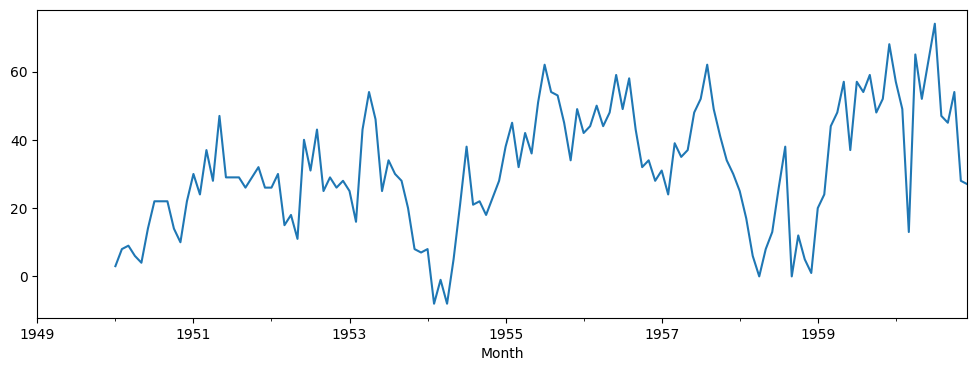

In [ ]:
# стационарность после сезонной разности
df["difference_seasonal"]= diff(df["Thousands of Passengers"], k_diff=0,k_seasonal_diff= 1,seasonal_periods= 12)
df["difference_seasonal"].plot(figsize=(12,4))

In [ ]:
adf_test(df["difference_seasonal"])

ADF тест                       -3.383021
p-value                         0.011551
# lags used                     1.000000
# наблюдения                  130.000000
критическое значение (1%)      -3.481682
критическое значение (5%)      -2.884042
критическое значение (10%)     -2.578770
Сильные доказательства против нулевой гипотезы
Отменяем 0 гипотезу
Данные стационарны


In [ ]:
len(df)

144

In [ ]:
# разделим на тестовый и тренировочный набор данных
train= df.iloc[:len(df)-12]
test= df.iloc[len(df)-12:]

In [ ]:
print(len(train))
print(len(test))

132
12


In [ ]:
# найдем порядок p,d,q
# ARIMA: обучение модели без сезонной составляющей
auto_arima_results= auto_arima(train["Thousands of Passengers"],
           start_p=0,
           start_q=0,
           max_p=3,
           max_q=3,
           m=1,
           d=None,
           seasonal=False,
           start_P=0,
           D=0,
           trace=True,
           error_action='ignore',
           suppress_warnings=True,
           stepwise=True)

auto_arima_results.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1277.589, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1268.313, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1264.738, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1276.259, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1258.440, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1262.608, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1263.896, Time=0.25 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1218.683, Time=1.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -603.341
Date:                Tue, 13 Jun 2023   AIC                           1218.683
Time:                        13:40:45   BIC                           1235.934
Sample:                    01-01-1949   HQIC                          1225.692
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7157      0.212      3.379      0.001       0.301       1.131
ar.L1          1.6431      0.028     57.904      0.000       1.587       1.699
ar.L2         -0.9129      0.027    -33.338      0.000      -0.967      -0.859
ma.L1         -1.8478      0.036    -51.463      0.000      -1.918      -1.777
ma.L2          0.9466      0.038     24.988      0.000       0.872       1.021
sigma2       564.8460     67.205      8.405      0.000     433.126     696.566
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 1.87
Prob(Q):                              0.36   Prob(JB):                         0.39
Heteroskedasticity (H):               6.40   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

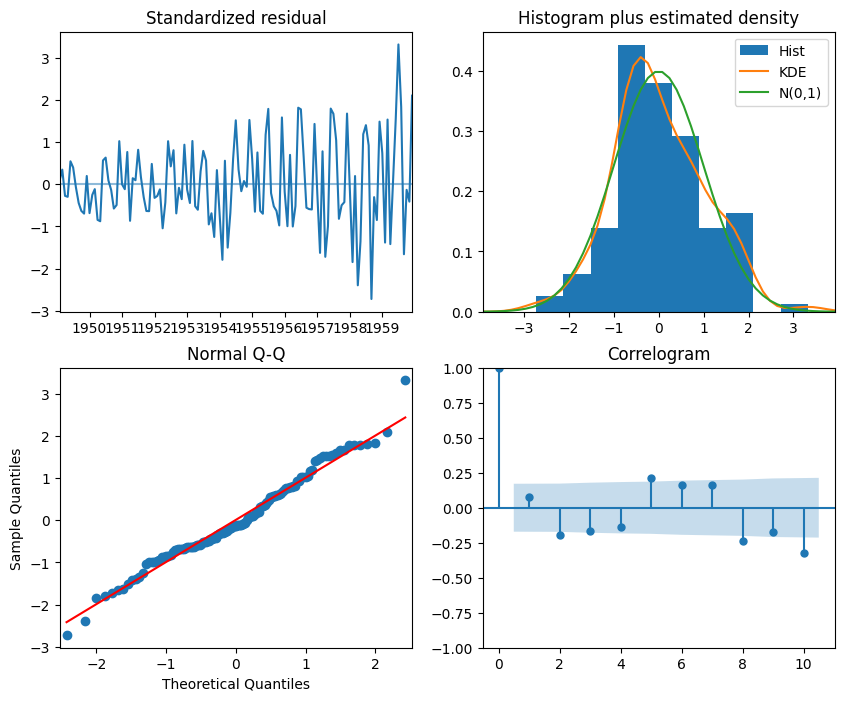

In [ ]:
# интерпретация ARIMA модели в виде графиков
auto_arima_results.plot_diagnostics(figsize=(10,8))
plt.show()

#### Train ARIMA model using p,d,q values from auto_arima

In [ ]:
# обучим модель ARIMA используя p,d,q из полученного результата по auto_arima
arima_model= ARIMA(train["Thousands of Passengers"], order= (2,1,2))
arima_model_fit= arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
normaltest(arima_model_fit.resid)
# если p-value не менее 0.05 , это означает, что остатки нормально распределены

NormaltestResult(statistic=14.0113003611032, pvalue=0.0009067441961382057)

In [ ]:
# сделаем прогноз на test наборе данных
start= len(train)
end= len(train) + len(test) -1

pred= arima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("ARIMA predictions")

<Axes: title={'center': 'Актуальность и Прогноз для Test набора данных'}, xlabel='Month'>

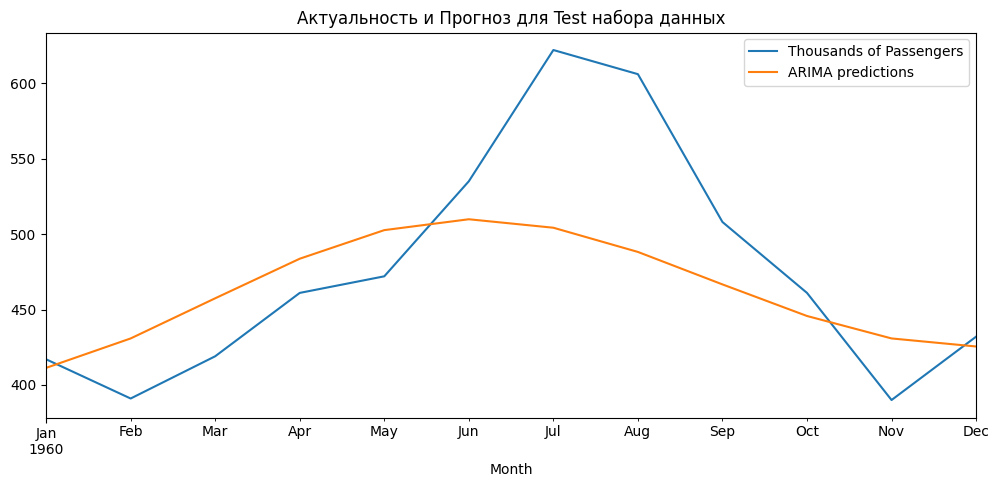

In [ ]:
title= "Актуальность и Прогноз для Test набора данных"
test["Thousands of Passengers"].plot(figsize=(12,5), title= title, legend=True);
pred.plot(legend=True)


In [ ]:
# оценим модель по штрафным баллам
mse= mean_squared_error(test["Thousands of Passengers"],pred)
rmse_arima= rmse(test["Thousands of Passengers"], pred)

print(f"RMSE= {rmse_arima} \n")
print(f"MSE= {mse}")

RMSE= 55.22283915688796 

MSE= 3049.561964547518


In [ ]:
# найдем порядок p,d,q
# ARIMA: обучение модели с сезонной составляющей
smodel = auto_arima(train["Thousands of Passengers"],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1022.029, Time=0.89 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.96 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.79 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=2.96 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.74 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.20 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.34 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.58 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.16 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.42 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Tue, 13 Jun 2023   AIC                            905.686
Time:                                    13:47:38   BIC                            919.623
Sample:                                01-01-1949   HQIC                           911.346
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE= 17.81560143047715 

MSE= 317.39565432961956


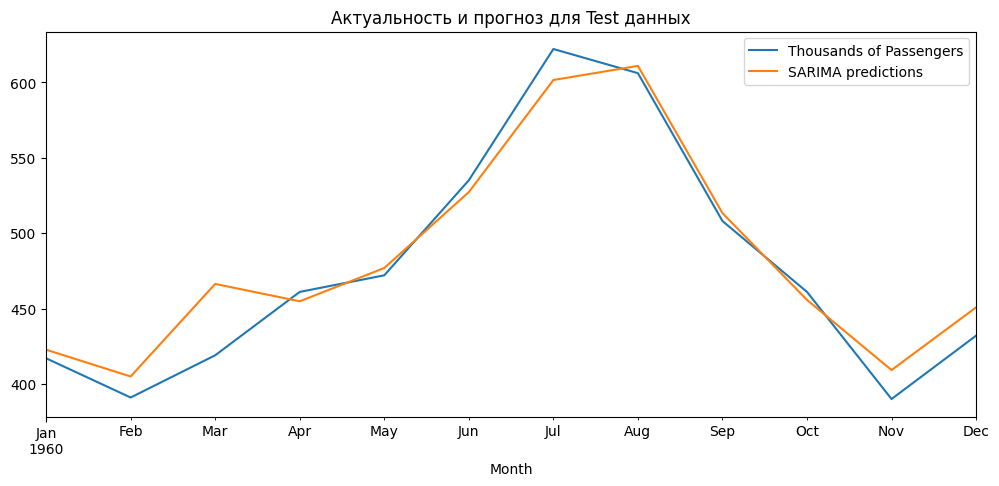

In [ ]:
# обучим модель
sarima_model= SARIMAX(train["Thousands of Passengers"], order= (3,0,0), seasonal_order= (0,1,0,12))
sarima_model_fit= sarima_model.fit()

# сделаем пронозы на Test данных
start= len(train)
end= len(train) + len(test) -1
pred= sarima_model_fit.predict(start=start, end=end, dynamic=False, typ="levels").rename("SARIMA predictions")

# построим прогноз
title= "Актуальность и прогноз для Test данных"
test["Thousands of Passengers"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

# оценим модель
mse= mean_squared_error(test["Thousands of Passengers"],pred)
rmse_sarima= rmse(test["Thousands of Passengers"], pred)

print(f"RMSE= {rmse_sarima} \n")
print(f"MSE= {mse}")

In [ ]:
# подсчитаем сезонный индекс
result_mul = seasonal_decompose(train['Thousands of Passengers'],   # 3 years
                                model='multiplicative',
                                extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

# соединим его с Train данными
train['month'] = train.index.month
train2 = pd.merge(train, seasonal_index, how='left', on='month')
train2.index = train.index  # переопределим первичный индекс


# соединим его с Test данными
test['month'] = test.index.month
test2 = pd.merge(test, seasonal_index, how='left', on='month')
test2.index = test.index  # переопределим первичный индекс

<ipython-input-88-f77908e28396>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['month'] = train.index.month
<ipython-input-88-f77908e28396>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['month'] = test.index.month


In [ ]:
# SARIMAX модель
sxmodel = auto_arima(train2["Thousands of Passengers"],
                     exogenous=train2[['seasonal']],
                    start_p=0,
                    start_q=0,
                    max_p=3,
                    max_q=3,
                    m=12,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',
                    suppress_warnings=True,
                    stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1022.029, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1022.234, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=906.857, Time=0.66 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=963.555, Time=0.39 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1192.711, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=907.180, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=908.543, Time=1.24 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=907.120, Time=0.41 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.32 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1021.611, Time=0.30 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=906.396, Time=0.58 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=906.075, Time=0.16 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=906.713, Time=0.42 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -447.843
Date:                            Tue, 13 Jun 2023   AIC                            905.686
Time:                                    13:50:50   BIC                            919.623
Sample:                                01-01-1949   HQIC                           911.346
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      5.5341      2.007      2.757      0.006       1.600       9.468
ar.L1          0.7049      0.095      7.393      0.000       0.518       0.892
ar.L2          0.2574      0.131      1.968      0.049       0.001       0.514
ar.L3         -0.1434      0.107     -1.338      0.181      -0.354       0.067
sigma2       101.0969     12.818      7.887      0.000      75.974     126.220
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               1.41   Skew:                            -0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Root Mean Square is 20.540661836746057 

Mean Square Error is 421.91878869155585


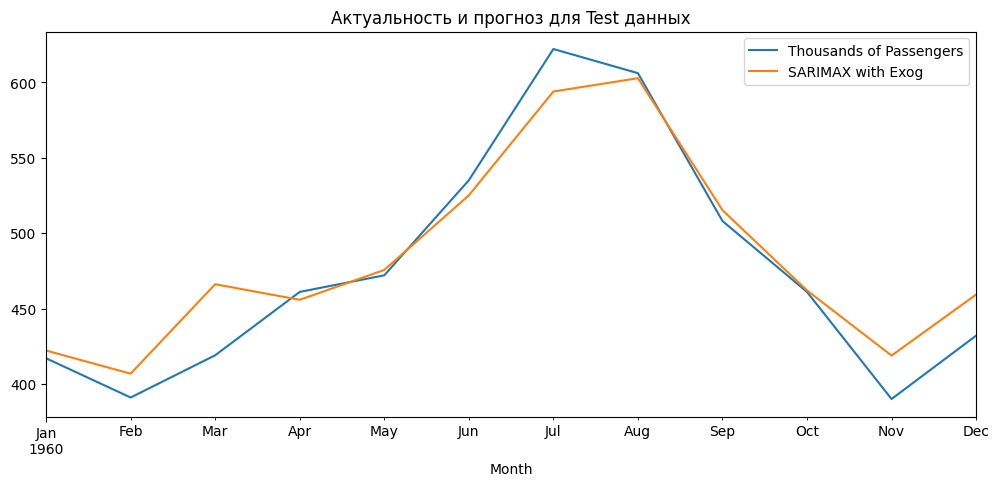

In [ ]:
# обучение модели
sarimax_model= SARIMAX(train2["Thousands of Passengers"], order= (1,1,0), seasonal_order= (1,0,0,12),exog=train2[['seasonal']])
sarimax_model_fit= sarimax_model.fit()

# прогнозы на Test
start= len(train)
end= len(train) + len(test) -1
pred= sarimax_model_fit.predict(start=start, end=end, dynamic=False, typ="levels",exog=test2[['seasonal']]).rename("SARIMAX with Exog")

title= "Актуальность и прогноз для Test данных"
test["Thousands of Passengers"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)

# оценка модели
mse= mean_squared_error(test["Thousands of Passengers"],pred)
rmse_sarimax= rmse(test["Thousands of Passengers"], pred)

print(f"Root Mean Square is {rmse_sarimax} \n")
print(f"Mean Square Error is {mse}")

In [ ]:
# перетренируем модель на всем объеме данных для прогноза
model= SARIMAX(df["Thousands of Passengers"], order= (3,0,0), seasonal_order= (0,1,0,12))
results= model.fit()

start= len(df)
end= len(df) + len(test) -1

pred= results.predict(start=start, end=end, dynamic=False, typ="levels").rename("Future Forecasts")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: title={'center': 'Актуальность и прогноз для Test данных'}, xlabel='Month'>

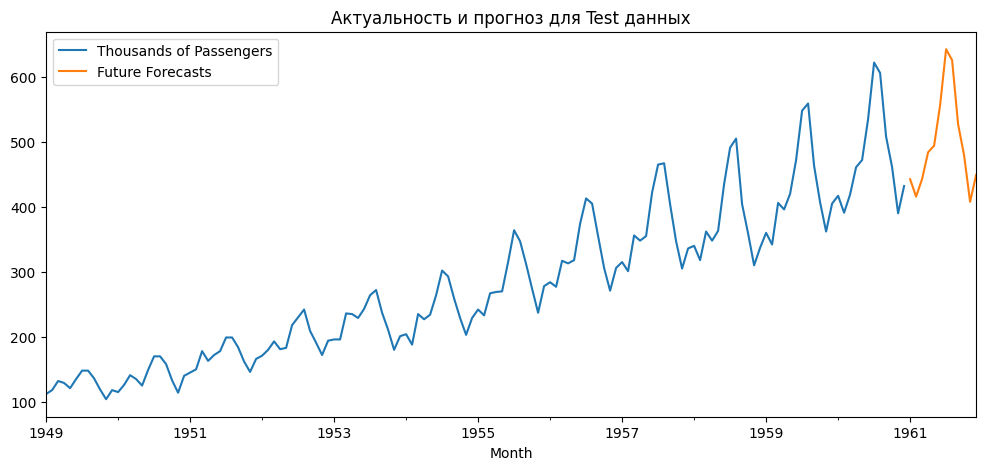

In [ ]:
# прогноз
df["Thousands of Passengers"].plot(figsize=(12,5), title= title, legend=True)
pred.plot(legend=True)